### Goal:
Based on provided Smiles string, get the blood-brain barrier penetration prediction from different models available through OpenRiskNet service (Lazar, CPSign)

#### Load libraries

In [18]:
from pip._internal import main as pip

import dst

try:
    import requests
except ImportError:
    pip(['install', 'request'])
    import requests

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import numpy as np
except ImportError:
    pip(['install', 'numpy'])
    import numpy as np
    
try:
    import json
except ImportError:
    pip(['install', 'json'])
    import json
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt
    
    
try:
    import pprint
except ImportError:
    pip(['install', 'pprint'])
    import pprint
    
try:
    from rdkit import Chem
except ImportError:
    print("Run the following from command line:\n\tconda install -c conda-forge rdkit")
    
try:
    from mordred import Calculator, descriptors
except ImportError:
    pip(['install', 'mordred'])
    from mordred import Calculator, descriptors
    
try:
    from jaqpotpy import Jaqpot
except ImportError:
    pip(['install', 'jaqpotpy'])
    from jaqpotpy import Jaqpot

#### Define which models are used (and set their PPV, NPV values)

In [2]:
# define models used
models = ['CPSign', 'Lazar', 'Jaqpot']

# initiate dictionaries to collect model properties/predictions
models_pred, models_prob, models_ppv, models_npv = {}, {}, {}, {}

models_npv['CPSign'] = 0.701
models_npv['Lazar'] = 0.489
models_npv['Jaqpot'] = 0.864

models_ppv['CPSign'] = 0.809
models_ppv['Lazar'] = 0.886
models_ppv['Jaqpot'] = 0.788

#### User enters Smiles string

In [14]:
smiles = input()

 CCCC


#### Lazar model

In [15]:
# parameters to access the LAZAR API
url = 'https://lazar.prod.openrisknet.org/model/5ae2dd885f1c2d01323270ee'
body = {'identifier': smiles}
headers = {'accept': 'text/csv'}

# call the LAZAR API
r = requests.post(url, headers=headers, data=body)

if r.status_code == 200:
    result = json.loads(r.text)
   
    try:
        pred = result['prediction']['value']
        
        if pred == None:
            pass
        elif pred == 'penetrating':
            pred = 'P'
        else:
            pred = 'N'
        
        # these probabilities could be used in DST approach, but currently we assume that predicted class has probability 1
        prob_p = result['prediction']['probabilities']['penetrating']
        prob_n = result['prediction']['probabilities']['non-penetrating']
        
    except KeyError:
        print('Prediction could not be made')
        pred, prob_p, prob_n = None, None, None
        
    models_pred['Lazar'] = pred
    models_prob['Lazar'] = 1.  # we assign probability 1 to the predicted class
else:
    print('Error in accessing LAZAR web service.')

#### CPSign model

In [64]:
# parameters to access the CPSign API
url = "http://blood-brain-barrier-penetration-cvap-cpsign.prod.openrisknet.org/v1/predict"
body = {'molecule': smiles}
headers = {'accept': 'application/json'}

# call the CPSign API
r = requests.get(url, headers=headers, params=body)

# extract the prediction from the API response
if r.status_code == 200:
    result = json.loads(r.text)
    
    result = pd.DataFrame(result['prediction']).set_index('label')
    
    prob_p = result.loc['penetrating', 'probability']
    prob_n = result.loc['non-penetrating', 'probability']
    
    if prob_p > prob_n:
        models_pred['CPSign'] = 'P'
        models_prob['CPSign'] = prob_p
    else:
        models_pred['CPSign'] = 'N'
        models_prob['CPSign'] = prob_n
    
else:
    print('Error in accessing CPSign web service.')

Error in accessing CPSign web service.


In [65]:
models_pred['CPSign'], models_prob['CPSign'] = 'P', 0.7

#### Jaqpot model

In [60]:
# generate MORDRED descriptors
mol = Chem.MolFromSmiles(smiles)
calc = Calculator(descriptors)
X = calc.pandas([mol])

# select only columns needed exactly for this jaqpot model
jaqpotCols = ['nAcid', 'MATS1p', 'GATS1se', 'nBondsD', 'RPCG', 'NssssN', 'SssssN', 'SddssS', 'IC1', 'Lipinski', 'PEOE_VSA3', 'PEOE_VSA8', 'PEOE_VSA11', 'SlogP_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA5', 'VSA_EState8', 'n7HRing', 'n6FRing']

# scale values according to the min max of reference dataset
Xref = pd.read_csv('compounds_descriptors.csv')
Xref = Xref[jaqpotCols]
X = pd.DataFrame(X[jaqpotCols])

X_scaled = (X - Xref.min()) / (Xref.max() - Xref.min())

# parameters to access the Jaqpot API
url = '4lQEkyB5vEPMoryODwPy'
jaqpot = Jaqpot("https://api-jaqpot.prod.openrisknet.org/jaqpot/services/")
apiKey = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJoX2p2Z3I3bWZ4VGJ3OHJLNW9Fb3dWWUVHUms2Z0hsLW9sSjdPUnQ3V2QwIn0.eyJqdGkiOiI3MzQ3MGFjMi0xYzM1LTQwOTktOTJhZS05NTAxYmQxZjk1OTYiLCJleHAiOjE1NzA4MzUxNjMsIm5iZiI6MCwiaWF0IjoxNTcwODM0MjYzLCJpc3MiOiJodHRwczovL3Nzby5wcm9kLm9wZW5yaXNrbmV0Lm9yZy9hdXRoL3JlYWxtcy9vcGVucmlza25ldCIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiI1NmUyNjk0MS0wMjk1LTRiNmUtOTRmOS03OWY3OWZiY2Y5NmMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJqYXFwb3QtdWkiLCJub25jZSI6Ik4wLjUwODY3MDk2MzU2MDM5NzYxNTcwODM0MjYyOTQ3IiwiYXV0aF90aW1lIjoxNTcwODMyNTQ2LCJzZXNzaW9uX3N0YXRlIjoiYTcyYzk2NDgtNWEwNC00NDNlLTkwODQtZDJmNTU3MzM1MWM3IiwiYWNyIjoiMCIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJzdGFuZGFyZC11c2VyIiwib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZW1haWwiLCJlbWFpbF92ZXJpZmllZCI6ZmFsc2UsIm5hbWUiOiJ0b21heiBtb2hvcmljIiwicHJlZmVycmVkX3VzZXJuYW1lIjoidG1vaG9yaWMiLCJnaXZlbl9uYW1lIjoidG9tYXoiLCJmYW1pbHlfbmFtZSI6Im1vaG9yaWMiLCJlbWFpbCI6Im1vaG9yaWMudG9tYXpAZ21haWwuY29tIn0.sQusM88ehrLQ6wn5bWhj_VZZntLIsmDhBrrKROsS2fvLcQx5PHlvRJENwsyQRq7cCIVEiaeeLyClhNUB49xsuYCHWv92vTTzz8CCK57OOAR2JekEpTiJouP8Zx4aFWpDBRK5YgDK9R0oCX3X80EgO38lu3KdOutoxB-QIg8rKq9Hddzm8yfCQsX6fMZDTc_kAUfbJHbzc53LTDxkqeKnsUbbETiG5pg7D1h0H9vcaX_P4sA0wtsEmpK344MV7HCoxbGp7B_vjXwBrHJIwYhadZTkNcYVFtNAqCQI6fcnht-7Wzg6ddFQwN8JNip1fFABBw63yE1gSh_ZzXj0OWxgDg"
jaqpot.set_api_key(apiKey)

# call the Jaqpot API
pred, predCol = jaqpot.predict(X_scaled, modelId=url)

# extract predicted value
prediction = pred.loc[0, predCol]

if prediction == 1:
    models_pred['Jaqpot'] = 'P'
elif prediction == 0:
    models_pred['Jaqpot'] = 'N'
else:
    models_pred['Jaqpot'] = None
    
models_prob['Jaqpot'] = 1.

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
  2019-10-11 22:53:20,981 - INFO - api key is set
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:851: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/conda/lib/python3.7/sit

#### Results of individual predictive models collected in dictionaries

In [61]:
print('models_pred:\n', models_pred, '\n\nmodels_prob:\n', models_prob, '\n\nmodels_ppv:\n', models_ppv, '\n\nmodels_npv:\n', models_npv)

models_pred:
 {'Lazar': 'P', 'Jaqpot': 'P'} 

models_prob:
 {'Lazar': 1.0, 'Jaqpot': 1.0} 

models_ppv:
 {'CPSign': 0.809, 'Lazar': 0.886, 'Jaqpot': 0.788} 

models_npv:
 {'CPSign': 0.701, 'Lazar': 0.489, 'Jaqpot': 0.864}


#### Consensus predictions

In [66]:
# if all models have valid predictions, then continue with consensus
validPred = True
for model in models:
    if (models_pred[model] == 'P') or (models_pred[model] == 'N'):
        pass
    else:
        validPred = False
        
if validPred:
    bel, pls, res = {}, {}, {}

    # Dempster rule
    bel['D'], pls['D'], res['D'] = dst.predict_Dempster(models_pred, models_prob, models_ppv, models_npv)

    # Yager rule
    bel['Y'], pls['Y'], res['Y'] = dst.predict_Yager(models_pred, models_prob, models_ppv, models_npv)
else:
    print('Some prediction is invalid.')

#### Visualization of predictions

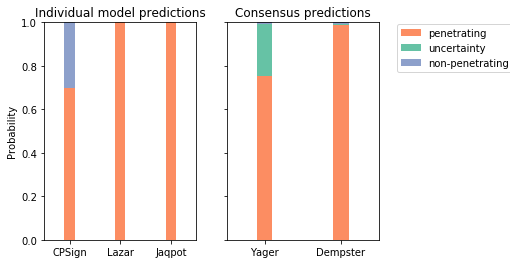

In [68]:
colorPenetrating = '#fc8d62'
colorNonpenetrating = '#8da0cb'
colorUncertainty = '#66c2a5'

def color_prediction(state):
    if state == 'P':
        return colorPenetrating
    else:
        return colorNonpenetrating
    
def color_antiprediction(state):
    if state == 'P':
        return colorNonpenetrating
    else:
        return colorPenetrating

fig, axs = plt.subplots(1, 2)

width = 0.2

# left plot - individual models
for i in range(len(models)):
    axs[0].bar(i, models_prob[models[i]], width, bottom=0, color=color_prediction(models_pred[models[i]]) )
    axs[0].bar(i, (1 - models_prob[models[i]]), width, bottom=models_prob[models[i]], color=color_antiprediction(models_pred[models[i]]))
    
axs[0].set_xticks(range(len(models)))    
axs[0].set_xticklabels(models)
axs[0].set_xlim(-0.5, len(models) - 0.5)
axs[0].set_ylabel('Probability')
axs[0].set_ylim(0, 1)
axs[0].set_title('Individual model predictions')

# right plot - consensus models
axs[1].bar(0, bel['Y']['P'], width, bottom=0, color=colorPenetrating)
axs[1].bar(0, (pls['Y']['P'] - bel['Y']['P']), width, bottom=bel['Y']['P'], color=colorUncertainty)
axs[1].bar(0, bel['Y']['N'], width, bottom=pls['Y']['P'], color=colorNonpenetrating)

p1 = axs[1].bar(1, bel['D']['P'], width, bottom=0, color=colorPenetrating)
p2 = axs[1].bar(1, (pls['D']['P'] - bel['D']['P']), width, bottom=bel['D']['P'], color=colorUncertainty)
p3 = axs[1].bar(1, bel['D']['N'], width, bottom=pls['D']['P'], color=colorNonpenetrating)

axs[1].set_xticks([0, 1])    
axs[1].set_xticklabels(['Yager', 'Dempster'])
axs[1].set_xlim(-0.5, 1.5)
axs[1].set_ylabel('')
axs[1].set_yticklabels('')
axs[1].set_ylim(0, 1)
axs[1].set_title('Consensus predictions')

fig.legend((p1[0], p2[0], p3[0]), ('penetrating', 'uncertainty', 'non-penetrating'), bbox_to_anchor=(1.2, 0.85))

fig.show()